# Spam Detection - Classification


![image](https://storage.googleapis.com/kaggle-datasets-images/483/982/15b24a8964e8d4afadff79a1a5543450/dataset-cover.jpg)


This project aims to perform the SMS spam classification task using the [SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset).


## Project Navigation

- [1. Required Libraries](#1)
- [2. Checking the target variable](#2)
- [3. Data pre-processing](#3)
- [4. SMS Spam Classification](#4)
  - [4.1. Creating Sentence Embeddings](#4-1)
  - [4.2. Plotting the Embeddings](#4-2)
  - [4.3. Splitting Data: Train/Test](#4-3)
  - [4.4. Baseline](#4-4)
  - [4.5. Model Hyperparameter Tuning](#4-5)


<a id="1"></a>

## 1. Required Libraries


In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

import random
import numpy as np
import pandas as pd
import charset_normalizer
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

seed = 42
np.random.seed(seed)
random.seed(seed)

2023-05-31 18:02:49.647807: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 18:02:51.078834: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# attempting to detect the csv file character encoding
with open("spam.csv", "rb") as csv:
    detected_encoding = charset_normalizer.detect(csv.read(250000))
    print(
        f"Detected encoding {detected_encoding['encoding']} with confidence level of {detected_encoding['confidence']}"
    )

df = pd.read_csv("spam.csv", encoding=detected_encoding["encoding"])
df = df.loc[:, ["v1", "v2"]]
df.info()

Detected encoding Windows-1252 with confidence level of 0.9988
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


<a id="2"></a>

## 2. Checking the target variable


Let's look into the target variable frequency distribution.


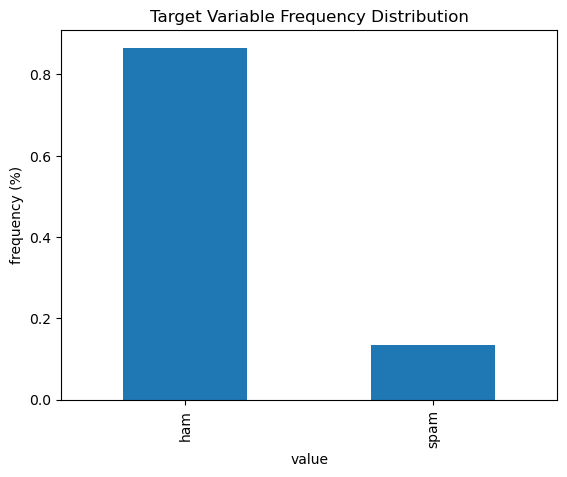

In [3]:
df["v1"].value_counts(normalize=True).plot(
    title="Target Variable Frequency Distribution",
    kind="bar",
    xlabel="value",
    ylabel="frequency (%)",
)
plt.show()


As were seen, the target variable is highly unbalanced.


<a id="3"></a>

## 3. Data pre-processing


Let's encode the target variable values with 0s for hams and 1s for spams.

In [4]:
binarizer = LabelBinarizer()
df["target"] = binarizer.fit_transform(df["v1"].values)

<a id="4"></a>

## 4. SMS Spam Classification


For the SMS Spam Classification task, we will use some of the state-of-the-art sentence embeddings techniques.
Sentence embedding is a collection of techniques in natural language processing where sentences are mapped into an intermediate representation (vectors of real numbers).
The embeddings (vectors) are used as inputs for the machine learning and deep learning models.


<a id="4-1"></a>

### 4.1. Creating Sentence Embeddings


In [5]:
transformer = SentenceTransformer("all-mpnet-base-v2")
embeddings = transformer.encode(df["v2"], show_progress_bar=False)
print(embeddings.shape)


(5572, 768)


<a id="4-2"></a>

### 4.2. Plotting the Embeddings


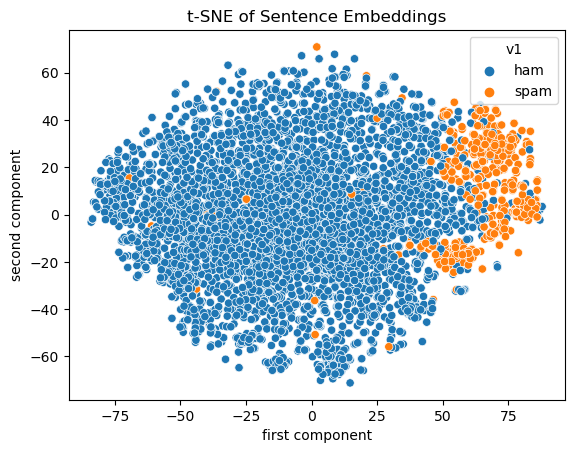

In [6]:
tsne = TSNE(random_state=seed)
converted = tsne.fit_transform(embeddings)
plt.title("t-SNE of Sentence Embeddings")
sns.scatterplot(x=converted[:, 0], y=converted[:, 1], hue=df["v1"])
plt.xlabel("first component")
plt.ylabel("second component")
plt.show()


Using the sentence transformer method, we were able to create a numeric representation of the SMS messages. This representations were seen to be clustered between hams and spams. This may be a good indicative of classification success in the next steps.


# <a id="modeling"></a>5. Modeling

In [7]:
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.25, shuffle=True, stratify=y, random_state=seed
)

print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")

X_train: (4179, 768)
X_test: (1393, 768)


In [8]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = [
    LogisticRegression(random_state=seed),
    KNeighborsClassifier(),
    GaussianNB(),
    SVC(random_state=seed),
    RandomForestClassifier(random_state=seed),
    ExtraTreesClassifier(),
    XGBClassifier(seed=seed),
    LGBMClassifier(random_state=seed)
]

kfold = StratifiedKFold(shuffle=True, random_state=seed)
scoring = "accuracy"

scores = []
for model in models:
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
    scores.append(score)

In [9]:
scores_df = pd.melt(pd.DataFrame(scores, index=map(lambda x: x.__class__.__name__, models)).reset_index(), "index", np.arange(0, 5)).rename(columns=dict(index="Model", variable="Fold", value="Score"))
scores_df.groupby("Model")["Score"].mean().sort_values(ascending=False).to_frame().reset_index()

,Model,Score
0,SVC,0.989472
1,LogisticRegression,0.983250
2,XGBClassifier,0.977986
3,KNeighborsClassifier,0.977029
4,LGBMClassifier,0.975832
5,GaussianNB,0.968174
6,RandomForestClassifier,0.958125
7,ExtraTreesClassifier,0.956450


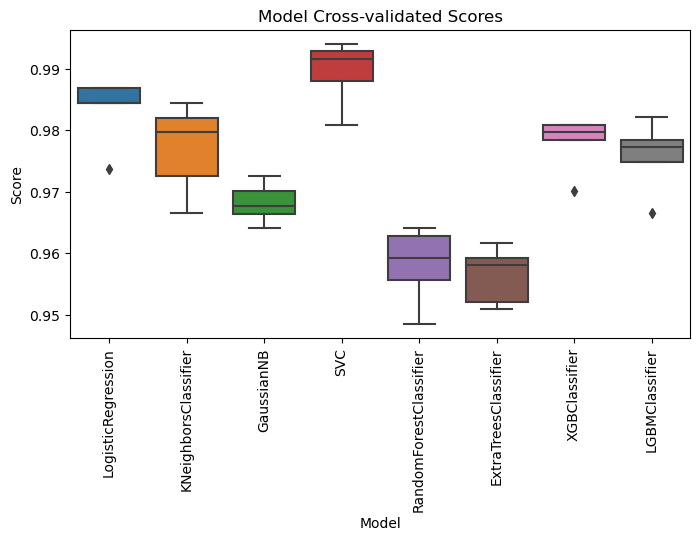

In [10]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=scores_df, x="Model", y="Score")
plt.title("Model Cross-validated Scores")
plt.xticks(rotation=90)
plt.show()

The SVM, Logistic Regression, XGBoost and KNN methods were seen to be the ones with higher accuracy in the previous tests. So we will try to improve their performances with hyperparameter tuning.

## <a id="tuning"></a>5.1. Hyperparameter Tuning

In this section we will use the GridSearchCV class to test multiple combinations of the hyperparameters for each model.

In [11]:
from sklearn.calibration import cross_val_predict
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.base import clone

def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, cm

def experiment_model(estimator, X, y, param_grid, cv, scoring="accuracy", n_jobs=-1):
    estimator = clone(estimator)

    gscv = GridSearchCV(
        estimator,
        param_grid=param_grid,
        cv=cv,
        n_jobs=n_jobs,
        scoring=scoring
    )
    gscv.fit(X, y)
    preds = cross_val_predict(gscv.best_estimator_, X, y, cv=cv, n_jobs=n_jobs)
    accuracy, precision, recall, f1, cm = metrics(y, preds)

    fig = plt.figure(figsize=(16, 4))
    fig.suptitle(f"{estimator.__class__.__name__}", fontsize=18)

    plt.subplot(131)
    plt.title("Precision x Recall Curve")

    if hasattr(gscv.best_estimator_, "predict_proba"):
        probas = cross_val_predict(gscv.best_estimator_, X, y, cv=cv, n_jobs=n_jobs, method="predict_proba")[:, 1]
        precisions, recalls, _ = precision_recall_curve(y, probas)
        fpr, tpr, _ = roc_curve(y, probas)
        roc_auc = roc_auc_score(y, probas)
    elif hasattr(gscv.best_estimator_, "decision_function"):
        scores = cross_val_predict(gscv.best_estimator_, X, y, cv=cv, n_jobs=n_jobs, method="decision_function")
        precisions, recalls, _ = precision_recall_curve(y, scores)
        fpr, tpr, _ = roc_curve(y, scores)
        roc_auc = roc_auc_score(y, scores)
    else:
        precisions, recalls, _ = precision_recall_curve(y, preds)
        fpr, tpr, _ = roc_curve(y, preds)
        roc_auc = roc_auc_score(y, preds)

    plt.plot(recalls, precisions, color="b")
    plt.plot([0, 1], [1, 0], "b--")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.subplot(132)
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, color="r")
    plt.plot([0, 1], [0, 1], "b--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.subplot(133)
    plt.title("Confusion Matrix")
    ConfusionMatrixDisplay(cm).plot(ax=plt.gca())

    fig.show()

    for metric, value in dict(accuracy=accuracy, precision=precision, recall=recall, f1=f1, roc_auc=roc_auc).items():
        print("%s: %.4f" % (metric, value))

    return gscv.best_params_

### <a id="svm"></a>5.1.1 SVM

accuracy: 0.9902
precision: 0.9943
recall: 0.9321
f1: 0.9622
roc_auc: 0.9975


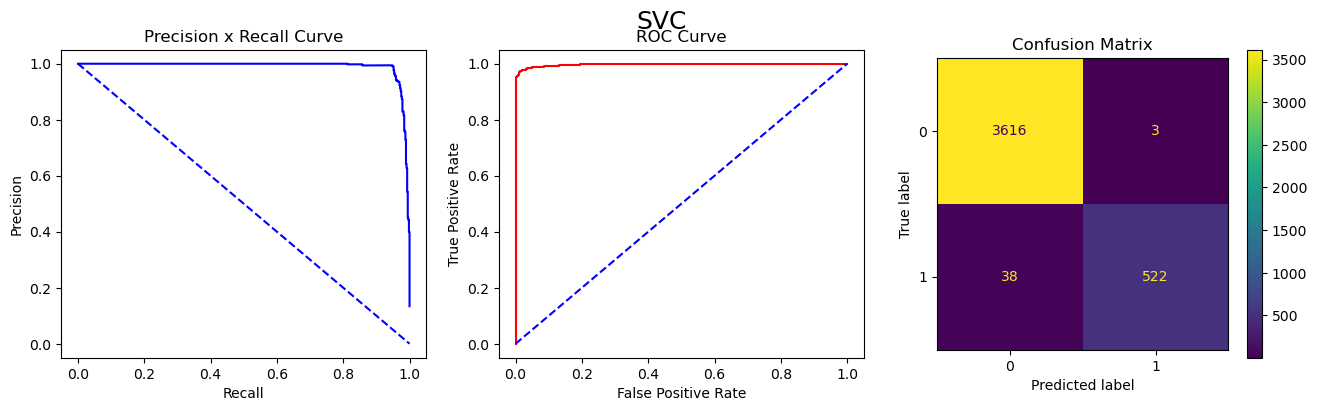

In [12]:
svc_params = experiment_model(
    SVC(random_state=seed, max_iter=10000),
    X_train, y_train,
    param_grid={
        "kernel": ["rbf", "linear", "sigmoid"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
    scoring="accuracy",
    n_jobs=-1
)

accuracy: 0.9888
precision: 0.9942
recall: 0.9214
f1: 0.9564
roc_auc: 0.9973


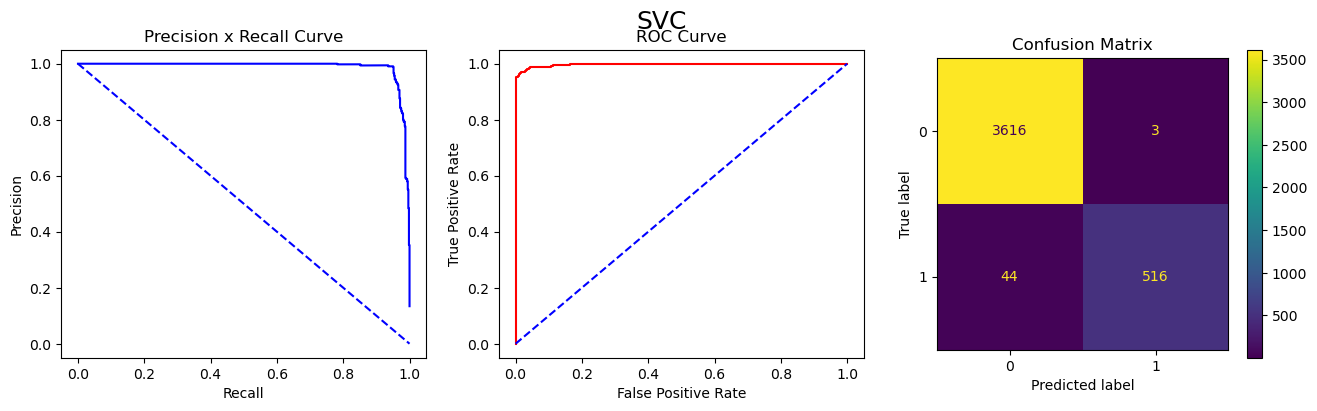

In [13]:
svc_poly_params = experiment_model(
    SVC(random_state=seed, max_iter=10000, kernel="poly"),
    X_train, y_train,
    param_grid={
        "degree": [2, 3, 4],
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
    scoring="accuracy",
    n_jobs=-1
)

### <a id="lr"></a>5.1.2 Logistic Regression

accuracy: 0.9899
precision: 0.9905
recall: 0.9339
f1: 0.9614
roc_auc: 0.9960


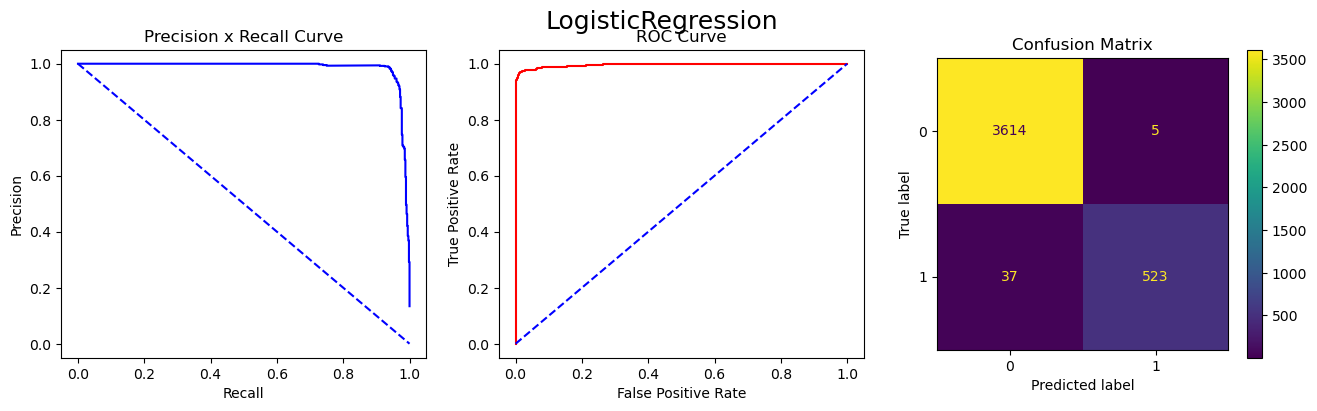

In [14]:
lr_params = experiment_model(
    LogisticRegression(random_state=seed),
    X_train, y_train,
    param_grid={
        "penalty": ["l1", "l2", "elasticnet"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
    scoring="accuracy",
    n_jobs=-1
)

### <a id="xgboost"></a>XGBoost

accuracy: 0.9847
precision: 0.9844
recall: 0.9000
f1: 0.9403
roc_auc: 0.9929


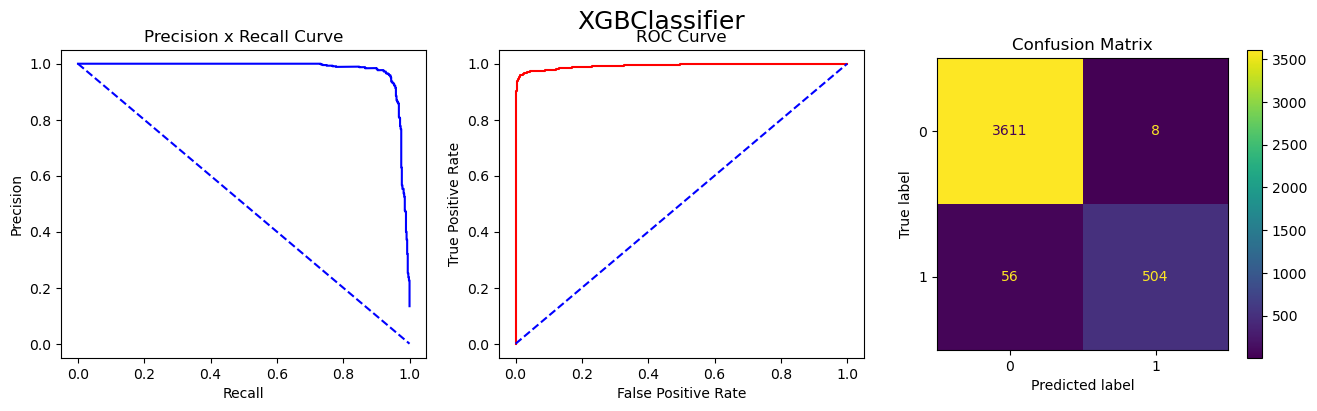

In [16]:
xgb_params = experiment_model(
    XGBClassifier(seed=seed),
    X_train, y_train,
    param_grid={
        "max_depth": [3, 5, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2, 0.3],
        # "subsample": np.arange(0.5, 1.0, 0.1),
        "colsample_bytree": np.arange(0.4, 1.0, 0.1),
        # "colsample_bylevel": np.arange(0.4, 1.0, 0.1),
        "n_estimators": [100, 500, 1000]
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
    scoring="accuracy",
    n_jobs=-1
)

### <a id="knn"></a>KNN

accuracy: 0.9835
precision: 0.9299
recall: 0.9482
f1: 0.9390
roc_auc: 0.9861


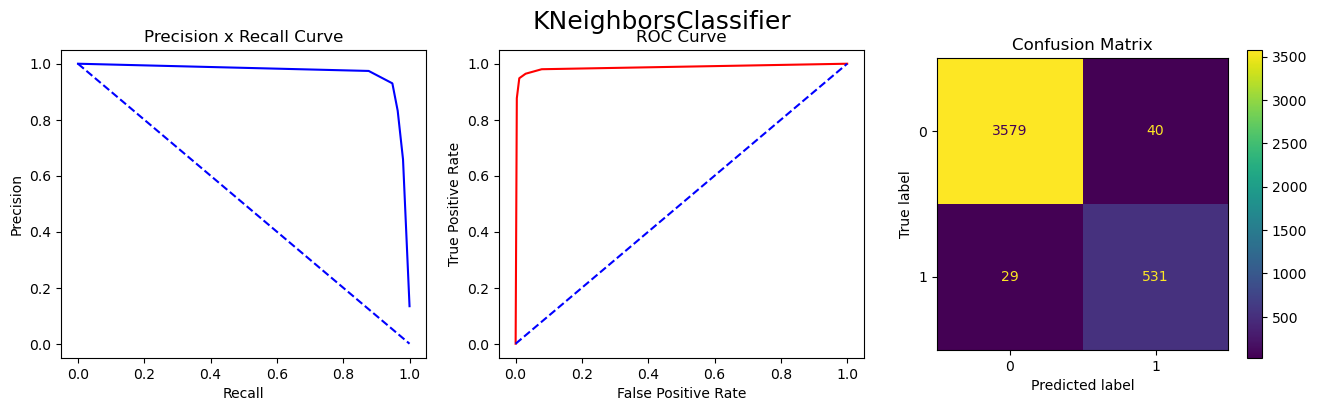

In [17]:
knn_params = experiment_model(
    KNeighborsClassifier(),
    X_train, y_train,
    param_grid={
        "n_neighbors": np.arange(1, 20),
        "p": [1, 2, 3]
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
    scoring="accuracy",
    n_jobs=-1
)

### <a id="voting"></a>Voting Classifier

Let's test the classification performance of a voting classifier including our best KNN and SVM models.

accuracy: 0.9885
precision: 0.9942
recall: 0.9196
f1: 0.9555
roc_auc: 0.9594


{}

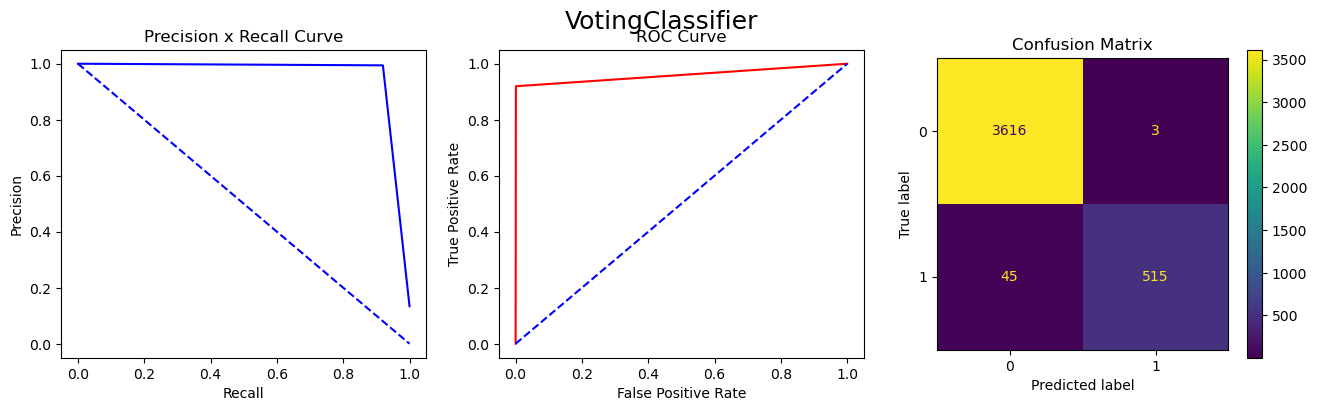

In [18]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(estimators=[
    ("KNN", KNeighborsClassifier(**knn_params)),
    ("SVM", SVC(max_iter=10000, random_state=seed, **svc_params)),
    ("LR", LogisticRegression(random_state=seed, **lr_params)),
    ("XGBoost", XGBClassifier(seed=seed, **xgb_params))
], voting="hard", n_jobs=-1)

experiment_model(
    voting,
    X_train, y_train,
    param_grid={},
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
    scoring="accuracy",
    n_jobs=-1
)